In [96]:
import cv2
import skimage
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.backend import epsilon
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from patchify import patchify
from tensorflow.keras.models import load_model
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
import networkx as nx
from skimage.morphology import skeletonize

In [80]:
cut_images = []
predicted_masks = []
post_processed_masks = []

In [27]:
folder = r'C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\1. Computer Vision\measurement'
for image in os.listdir(folder):
    image_path = os.path.join(folder, image)
    im = cv2.imread(image_path, 0)
    if image.endswith(".tif"):
        im = cv2.medianBlur(im, 5)
        th, output_im = cv2.threshold(im, 10, 255, cv2.THRESH_BINARY)
        output_im = cv2.dilate(output_im, np.ones((3, 3), np.uint8), iterations=3)
        output_im = cv2.erode(output_im, np.ones((3, 3), np.uint8), iterations=10)

        retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

        x,y,w,h,_ = stats[largest_label]

        im = im[y:y+h, x:x+w]
        cut_images.append(im)
    else:
        print(image_path)

C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\1. Computer Vision\measurement\cut


In [39]:
num_images = len(cut_images)
patch_dir = r'C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\1. Computer Vision\pipeline_patches'

In [40]:
def create_and_save_patches(patch_size):
    def padder(image, patch_size):
        h = image.shape[0]
        w = image.shape[1]
        height_padding = ((h // patch_size) + 1) * patch_size - h
        width_padding = ((w // patch_size) + 1) * patch_size - w

        top_padding = int(height_padding/2)
        bottom_padding = height_padding - top_padding

        left_padding = int(width_padding/2)
        right_padding = width_padding - left_padding        
        padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        return padded_image

    for img_idx, image in enumerate(cut_images):
        print(img_idx)
        image = padder(image, patch_size)

        # Create image patches
        image_patches = patchify(image, (patch_size, patch_size), step=patch_size)
        image_patches = image_patches.reshape(-1, patch_size, patch_size)

        # Save image patches
        for patch_index, img_patch in enumerate(image_patches):
                image_patch_path = f'{patch_dir}\\{img_idx}_{patch_index}.png'
                cv2.imwrite(image_patch_path, img_patch)

In [41]:

create_and_save_patches(256)

0
1
2


In [42]:
def create_weight_map(mask_shape, center_weight=10, border_weight=1):
    """
    Create a weight map for a mask, with higher weights in the center and lower weights at the borders.
    
    :param mask_shape: Tuple, the shape of the mask for which the weight map is created.
    :param center_weight: Float, the weight for the central region of the mask.
    :param border_weight: Float, the weight for the border region of the mask.
    :return: Numpy array, the weight map.
    """
    # Create a grid of the same shape as the mask
    xx, yy = np.meshgrid(np.arange(mask_shape[1]), np.arange(mask_shape[0]))
    
    # Calculate the center of the mask
    center_x, center_y = mask_shape[1] // 2, mask_shape[0] // 2
    
    # Calculate the distance of each point from the center
    distances_from_center = np.sqrt((xx - center_x)**2 + (yy - center_y)**2)
    
    # Normalize distances to range between 0 and 1
    max_distance = np.sqrt(center_x**2 + center_y**2)
    normalized_distances = distances_from_center / max_distance
    
    # Create the weight map where the center has `center_weight` and borders have `border_weight`
    weight_map = (1 - normalized_distances) * (center_weight - border_weight) + border_weight
    
    return weight_map

# Example usage:
mask_shape = (256, 256)  # The shape of your mask patches
weight_map = create_weight_map(mask_shape, center_weight=10, border_weight=1)


In [43]:
class F1Score(Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), tf.float32)          # for mixed precision training
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, "float"), axis=0)
        false_positives = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, "float"), axis=0)
        false_negatives = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), "float"), axis=0)

        self.true_positives.assign_add(tf.reduce_sum(true_positives))
        self.false_positives.assign_add(tf.reduce_sum(false_positives))
        self.false_negatives.assign_add(tf.reduce_sum(false_negatives))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + epsilon())
        return 2 * (precision * recall) / (precision + recall + epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

# Define IoU
class IoU(Metric):
    def __init__(self, name='iou', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return self.intersection / (self.union + epsilon())

    def reset_state(self):
        self.intersection.assign(0)
        self.union.assign(0)

In [44]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate

def resnet_unet(input_size, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size, classes=1)

    # Use feature maps from ResNet model
    conv4 = base_model.get_layer('conv4_block6_out').output
    conv3 = base_model.get_layer('conv3_block4_out').output
    conv2 = base_model.get_layer('conv2_block3_out').output
    conv1 = base_model.get_layer('conv1_relu').output

    up4 = UpSampling2D((2, 2))(conv4)
    up4 = concatenate([up4, conv3])
    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Dropout(0.2)(up4)
    
    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([up3, conv2])
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Dropout(0.2)(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([up2, conv1])
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Dropout(0.2)(up2)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Dropout(0.2)(up1)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


def weighted_loss(y_true, y_pred, weights):
    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Apply the weights: element-wise multiplication
    weighted_bce = bce * weights
    
    # Return the mean loss
    return tf.reduce_mean(weighted_bce)

def create_weighted_loss(weights):
    def loss(y_true, y_pred):
        return weighted_loss(y_true, y_pred, weights)
    return loss

weight_map_tensor = tf.convert_to_tensor(weight_map, dtype=tf.float32)

weighted_loss_function = create_weighted_loss(weight_map_tensor)

model = resnet_unet(input_size=(256, 256, 3), num_classes=1)
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer, 
    loss=weighted_loss_function, 
    metrics=[F1Score(), IoU()]
)

In [46]:
model_path = r'C:\Users\benjm\Downloads\Workspace\modelV10.h5'  # Replace with your actual model file path

# Load the model
model = load_model(model_path, custom_objects={'F1Score': F1Score(), 'IoU': IoU(), 'loss': weighted_loss_function})

# Display the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

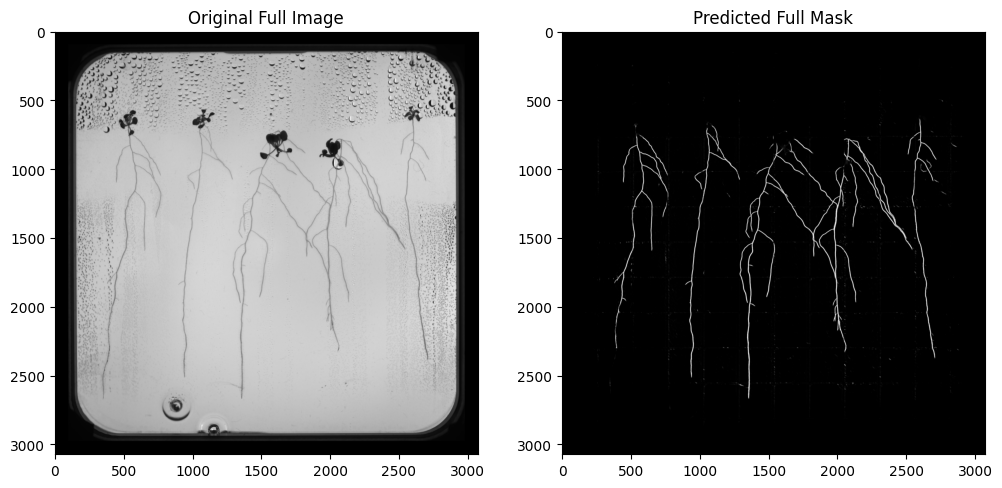

In [81]:
val_img_dir = r'C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\1. Computer Vision\pipeline_patches'
val_img_dir = glob.glob(os.path.join(val_img_dir, '*.png'))

# Initialize a dictionary to hold the patches for each image
img_patches = {}

# Load and sort patches
for patch_path in val_img_dir:
    file_name = os.path.basename(patch_path)
    index, patch_index = map(int, file_name.replace('.png', '').split('_'))
    patch_img = cv2.imread(patch_path)

    if index not in img_patches:
        img_patches[index] = {}

    img_patches[index][patch_index] = patch_img

# Now predict masks and reassemble
for index in sorted(img_patches.keys()):
    patches = img_patches[index]
    patch_list = [patches[i] for i in sorted(patches.keys())]

    # Reshape patches for prediction (assuming they are square)
    patch_size = patch_list[0].shape[0]  # Assuming square patches
    num_patches_per_side = int(np.sqrt(len(patch_list)))  # Assuming square layout of patches

    batch_size = 8
    num_patches = len(patch_list)
    patch_list_array = np.array(patch_list)

    predicted_patches = []
    for i in range(0, num_patches, batch_size):
        batch = patch_list_array[i:i + batch_size]
        predicted_mask_batch = model.predict(batch/255)
        predicted_patches.extend(predicted_mask_batch)

    # Convert list of patches into array for unpatchify
    predicted_patches_array = np.array(predicted_patches)
    
    combined_predicted_patches = predicted_patches_array[:,:,:,0]      #np.sum(predicted_patches_array, axis=-1)

    predicted_patches_array = combined_predicted_patches.reshape((num_patches_per_side, num_patches_per_side, patch_size, patch_size))

    patch_list_array = patch_list_array.reshape((num_patches_per_side, num_patches_per_side, patch_size, patch_size, 3))

    def manual_unpatchify(patches, full_image_size):
        num_patches_per_side,_ ,  patch_height, patch_width = patches.shape[:4]
        full_image = np.zeros(full_image_size, dtype=patches.dtype)

        for i in range(num_patches_per_side):
            for j in range(num_patches_per_side):
                if len(patches.shape) == 5:
                    full_image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width, :] = patches[i, j]
                else:  # If patches do not include a channel dimension
                    full_image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width] = patches[i, j]

        return full_image
    # Reconstruct the full image manually
    full_original_image = manual_unpatchify(patch_list_array, (3072, 3072, 3))
    full_predicted_mask = manual_unpatchify(predicted_patches_array, (3072, 3072))
    full_predicted_mask = (full_predicted_mask * 255).astype(np.uint8)

    predicted_masks.append(full_predicted_mask)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(full_original_image)
plt.title('Original Full Image')

plt.subplot(1, 2, 2)
plt.imshow(full_predicted_mask, cmap='gray')
plt.title('Predicted Full Mask')

plt.show()

In [93]:
import cv2
import numpy as np

def circularity(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return 4 * np.pi * (area / (perimeter * perimeter))

def process_mask(gray):
    _, binary = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    close = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=4)
    open = cv2.morphologyEx(close, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8), iterations=4)

    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(close, 4, cv2.CV_32S)
    density_threshold = 0.4

    # Initialize an empty mask
    component_mask = np.zeros(gray.shape, dtype=np.uint8)

    # Accumulate components that meet the density and circularity conditions
    for i, stat in enumerate(stats[1:], start=1):
        x, y, w, h, area = stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP], stat[cv2.CC_STAT_WIDTH], stat[cv2.CC_STAT_HEIGHT], stat[cv2.CC_STAT_AREA]
        density = area / (w * h)
        if y < 500 or y > 2000:
            continue

        # Extract the component as a separate mask
        single_component_mask = np.zeros_like(binary)
        single_component_mask[labels_im == i] = 255

        # Find contours and calculate circularity
        contours, _ = cv2.findContours(single_component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        circ_value = 0
        if contours:
            circ_value = circularity(max(contours, key=cv2.contourArea))

            # Check for area, density, and non-circularity
        if area > 2000 and density < density_threshold and circ_value < 0.3:
            component_mask[labels_im == i] = 255

    return component_mask

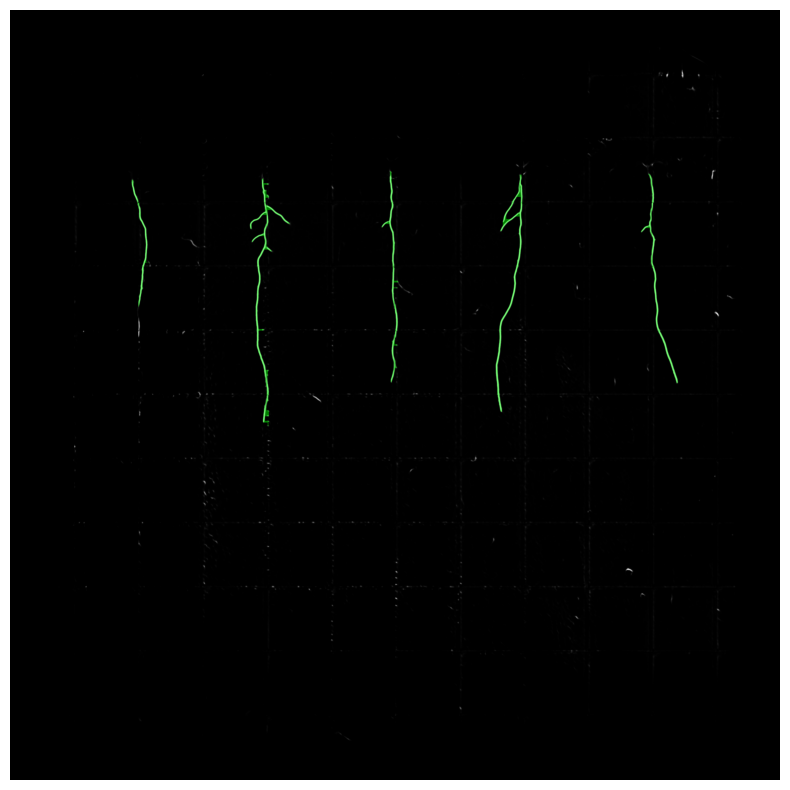

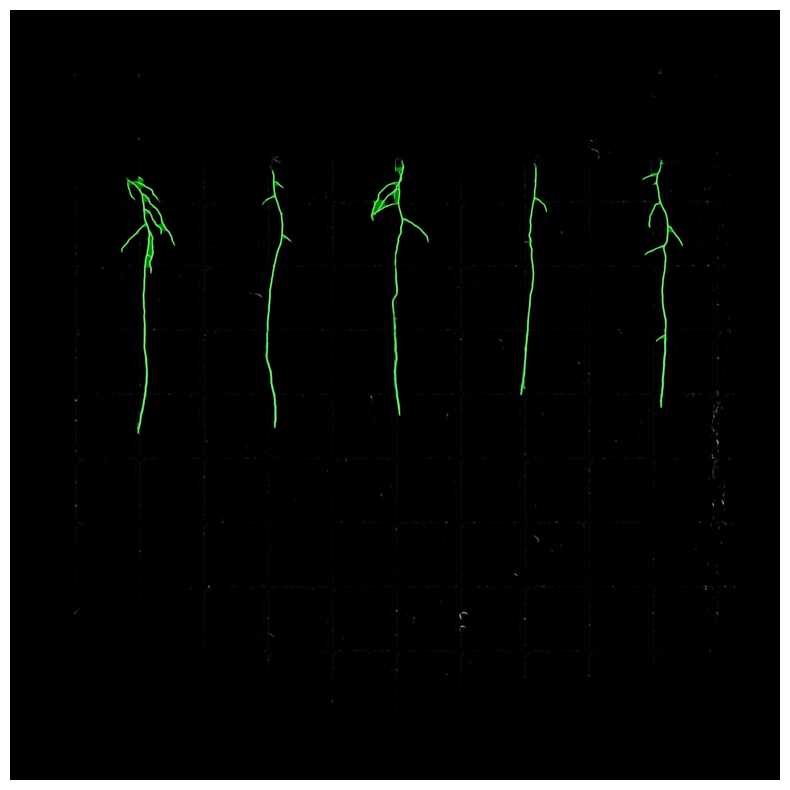

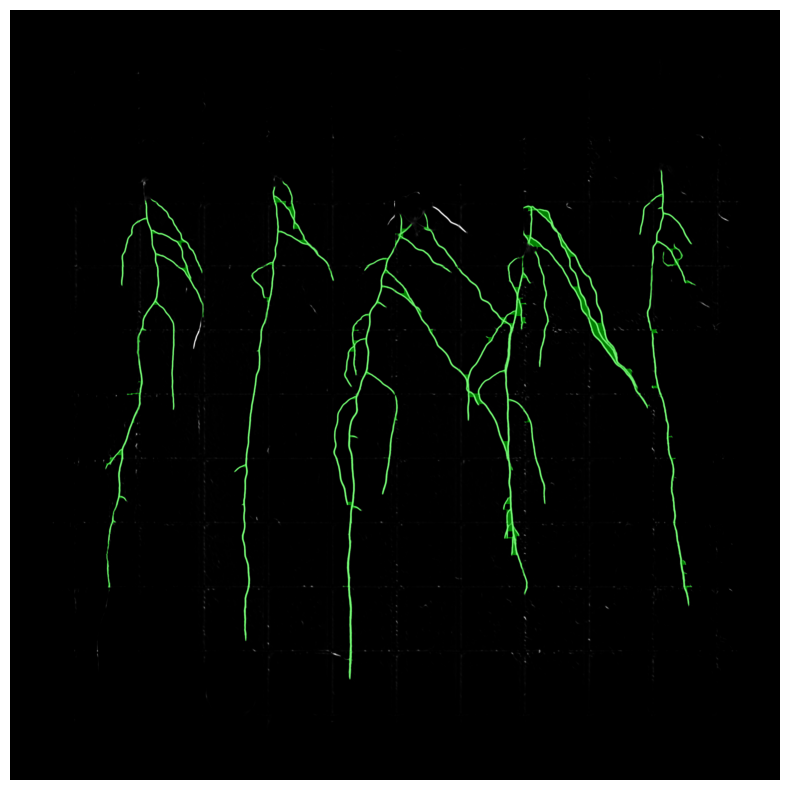

In [95]:
post_processed_masks = []
for img in predicted_masks:
        mask = process_mask(img)
        overlay = img.copy()
        overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        overlay[mask == 255] = (0, 255, 0)  # Green color for the overlay of the mask

        # Combine the image and the overlay
        alpha = 0.5  # Transparency factor.
        combined = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide the axis
        post_processed_masks.append(mask)

plt.show()


In [97]:
skeletonized = []

for index, mask in enumerate(post_processed_masks):
    _, binary_image = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    skelmask = skeletonize(binary_image)
    skeletonized.append(skelmask)
    print(index)

0
1
2


In [98]:
simple_skeleton_branch_data = {}
for i, skel in enumerate(skeletonized):
    if not np.any(skel):  # Check if the image is not all zeros
        print(f"Skeletonized image at index {i} is empty.")
    else:
        # Process non-empty skeletons
        simple_skeleton_branch_data[i] = summarize(Skeleton(skel))
        simple_skeleton_branch_data[i].sort_values(by="branch-distance", ascending=False)

In [99]:
def assign_plant_id(x_coordinate):
    if x_coordinate < 750:
        return 1
    elif x_coordinate < 1250:
        return 2
    elif x_coordinate < 1750:
        return 3
    elif x_coordinate < 2250:
        return 4
    else:
        return 5

In [101]:
import csv

def draw_main_root(image, skeleton_branch_data, u):
    info_image = np.copy(image).astype(np.uint8)  # Convert to uint8 if needed
    info_image *= 255
    main_root_lengths = {}
    lateral_root_lengths = {}

    for skeleton_id, group in skeleton_branch_data.groupby('skeleton-id'):
        G = nx.Graph()
        lateral_root_lengths[skeleton_id] = []
        
        # Add edges based on branch data, with actual lengths as weights
        for index, row in group.iterrows():
            src = (int(row['image-coord-src-1']), int(row['image-coord-src-0']))
            dst = (int(row['image-coord-dst-1']), int(row['image-coord-dst-0']))
            length = row['branch-distance']  # The actual length of the branch segment
            G.add_edge(src, dst, weight=length)

        endpoints = [node for node, degree in G.degree() if degree == 1]
        topmost_point = min(G.nodes, key=lambda point: point[1])
        
        # Initialize variables to store the longest path
        longest_path = []
        max_path_length = 0

        # Find the longest path based on actual branch lengths
        for end_point in endpoints:
            if topmost_point != end_point:
                try:
                    length, path = nx.single_source_dijkstra(G, topmost_point, end_point, weight='weight')
                    if length > max_path_length:
                        longest_path = path
                        max_path_length = length
                except nx.NetworkXNoPath:
                    continue
        
        # Draw the longest path on the image
        for i in range(len(longest_path) - 1):
            point1 = longest_path[i]
            point2 = longest_path[i + 1]
            cv2.line(info_image, point1, point2, color=(255, 255, 0), thickness=2)

        plant_id = assign_plant_id(topmost_point[0])
        main_root_lengths[plant_id] = max_path_length
        
        for edge in G.edges(data=True):
            if not (edge[0] in longest_path and edge[1] in longest_path):
                lateral_length = edge[2]['weight']
                lateral_root_lengths[skeleton_id].append(lateral_length)

    for plant_id in range(1, 6):
        main_root_lengths.setdefault(plant_id, 0)
    
    sorted_main_root_lengths = dict(sorted(main_root_lengths.items()))
    for id, length in sorted_main_root_lengths.items():
        with open('export.csv', mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([f'test_image_{u+1}_plant_{id}', length])

    # Display the image with the longest paths drawn
    plt.figure(figsize=(12, 12))
    plt.imshow(info_image)
    plt.axis('off')
    plt.show()

    return main_root_lengths, lateral_root_lengths

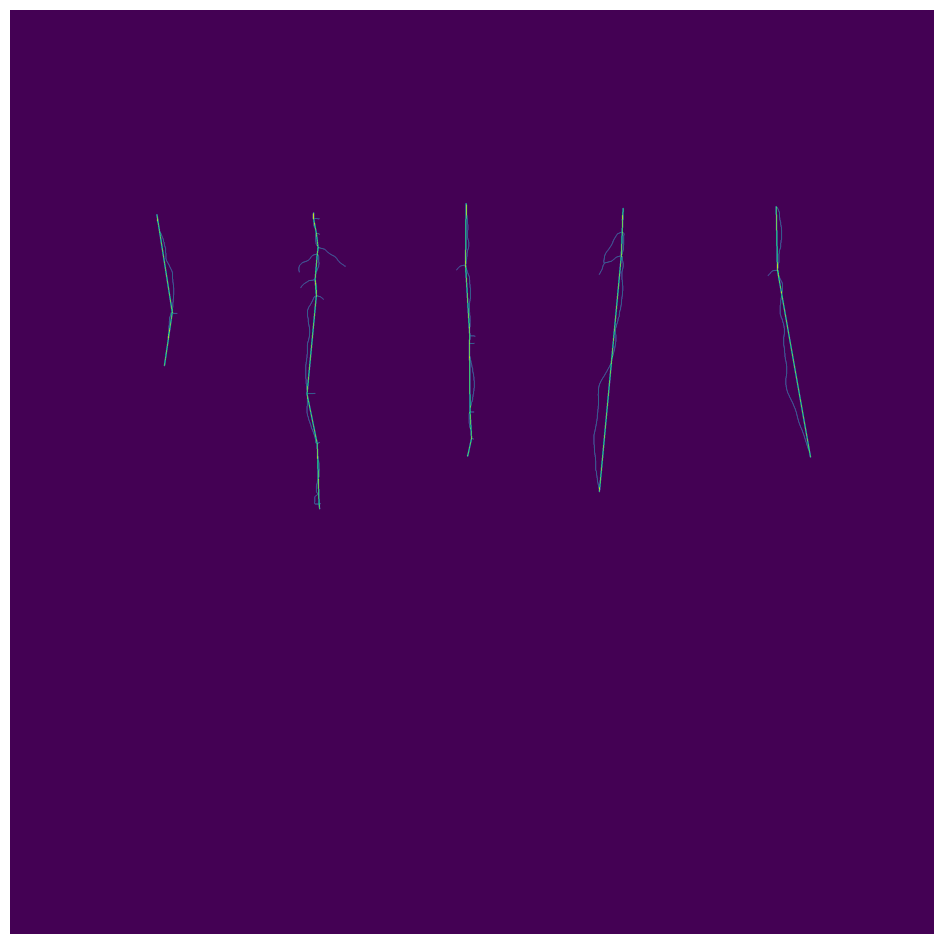

Lateral root lengths for skeleton 0: [37.62741699796952, 18.414213562373096, 16.414213562373096, 13.82842712474619, 7.82842712474619]
Lateral root lengths for skeleton 1: [40.04163056034261]
Lateral root lengths for skeleton 2: [135.36753236814707, 66.35533905932735, 45.4558441227157]
Lateral root lengths for skeleton 3: [20.242640687119287, 12.242640687119286, 118.6101730552663, 99.15432893255065, 60.355339059327335, 28.970562748477146, 27.82842712474619, 10.071067811865476, 5.414213562373095]
Lateral root lengths for skeleton 4: [17.65685424949238]


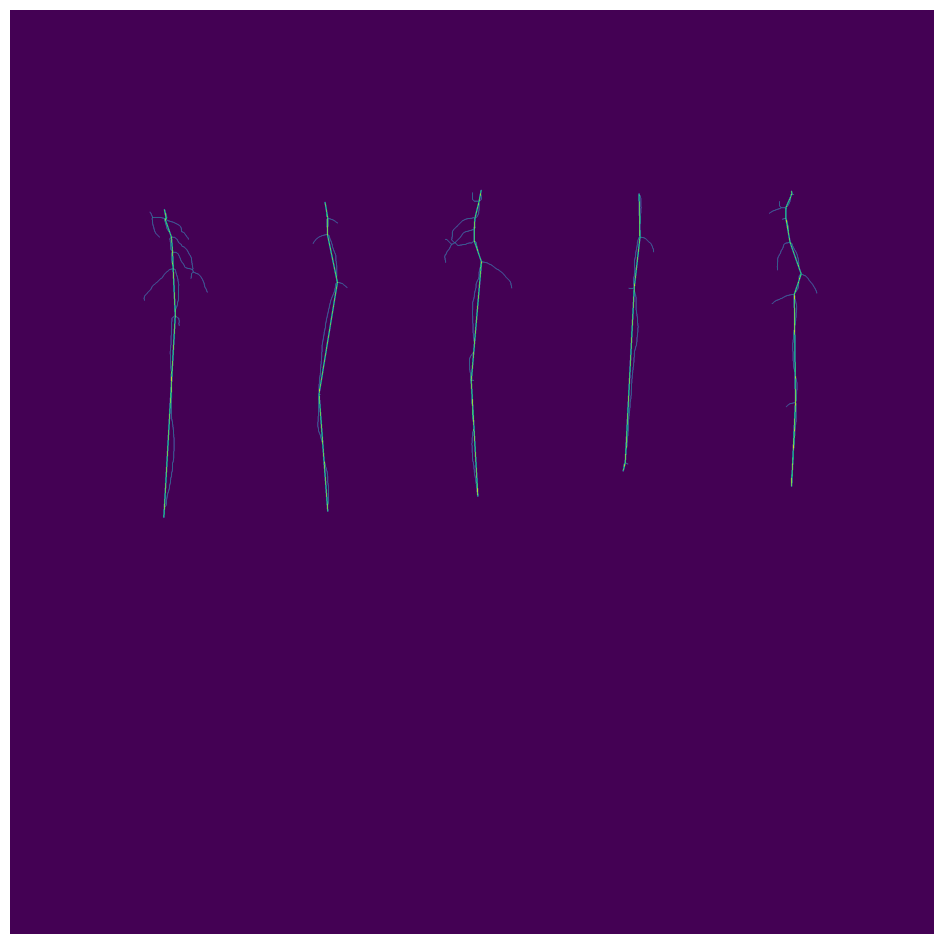

Lateral root lengths for skeleton 0: [46.89949493661167, 138.6101730552664, 3.0, 12.65685424949238, 83.74011537017753, 73.52691193458116, 26.62741699796953, 71.94112549695426, 148.16652224137036, 9.65685424949238]
Lateral root lengths for skeleton 1: [6.82842712474619, 16.0, 23.07106781186548, 46.87005768508879, 13.242640687119286, 117.84062043356589, 90.22539674441612, 86.84062043356587, 37.21320343559643]
Lateral root lengths for skeleton 2: [76.8406204335659, 19.65685424949238, 10.65685424949238]
Lateral root lengths for skeleton 3: [39.62741699796952, 62.76955262170043, 40.04163056034261, 4.82842712474619]
Lateral root lengths for skeleton 4: [114.46803743153538, 21.313708498984763, 44.07106781186547, 76.76955262170041, 148.6101730552664, 101.91168824543136, 10.242640687119286, 155.20815280171306, 41.38477631085024, 24.899494936611667, 92.32590180780446]


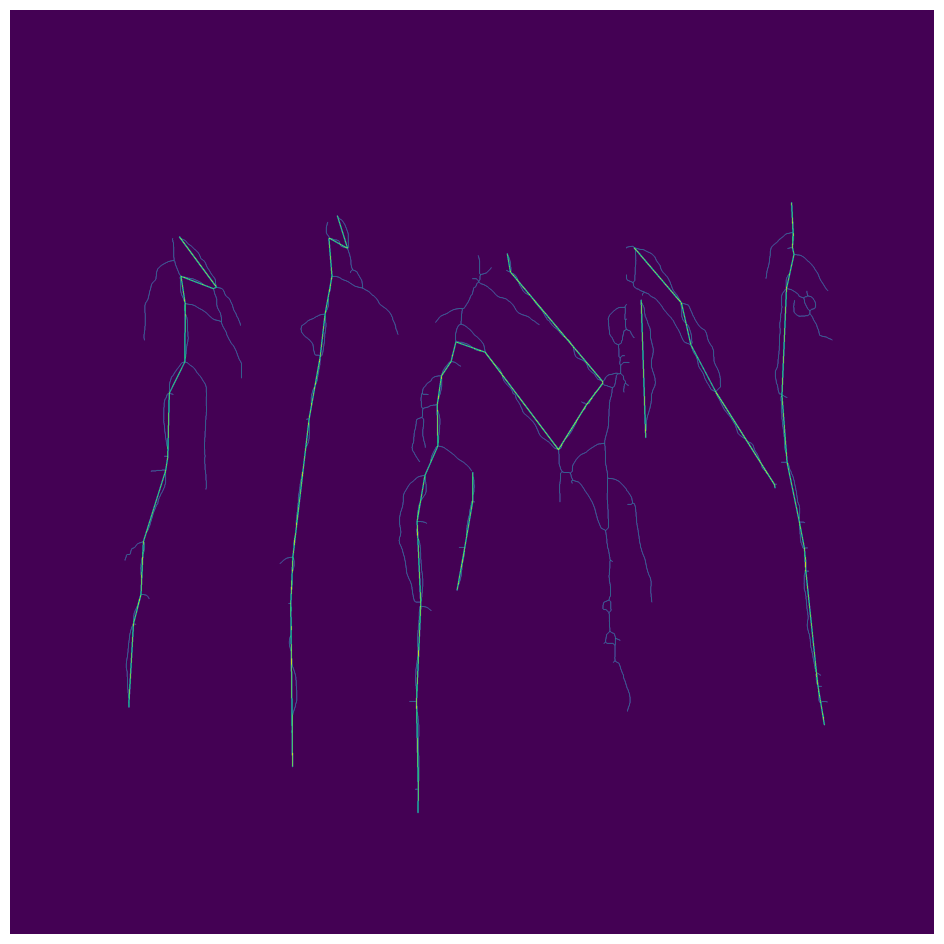

Lateral root lengths for skeleton 0: [204.92388155425124, 17.242640687119287, 182.45079348883255, 72.59797974644663, 15.899494936611667, 50.87005768508878, 19.899494936611667, 17.242640687119287, 77.59797974644663, 11.0, 66.45584412271567, 36.31370849898476, 1.4142135623730951, 132.29646455628162, 19.0, 18.82842712474619, 11.242640687119287, 11.65685424949238, 16.485281374238575, 12.0, 23.656854249492383]
Lateral root lengths for skeleton 1: [77.6274169979695, 59.2132034355964, 2.0, 118.15432893255063, 79.76955262170044, 12.899494936611667, 212.24978336205587, 9.414213562373096, 52.112698372208065, 7.414213562373095]
Lateral root lengths for skeleton 2: [168.33809511662434, 76.48528137423857, 322.8944443027285, 62.112698372208065, 144.43860018001254, 120.59797974644661, 215.75230867899742, 466.5512985522208, 14.656854249492381, 12.242640687119287, 51.48528137423856, 101.91168824543136, 34.55634918610405, 8.82842712474619, 2.0]
Lateral root lengths for skeleton 3: [32.31370849898477, 12

In [102]:
with open('export.csv', mode='w', newline='') as file:  # Use 'w' mode to write headers
    writer = csv.writer(file)
    writer.writerow(["Plant ID", "Length (px)"])

for i, image in enumerate(skeletonized):
    if not np.any(image):  # Check if the image is not all zeros
        print(f"Skeletonized image at index {i} is empty.")
    else:
        main_root_lengths, lateral_root_lengths = draw_main_root(image, simple_skeleton_branch_data[i], i)
        for skeleton_id, lengths in lateral_root_lengths.items():
            print(f"Lateral root lengths for skeleton {skeleton_id}: {lengths}")